In [1]:
!pip install category_encoders

     |████████████████████████████████| 81kB 9.4MB/s 


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders.basen import BaseNEncoder

#Training dataset

In [4]:
missing_values = ["n/a", "na", "--", "NONE", "None", "none", "NA", "N/A",'inf','-inf', '?', 'Null', 'NULL']
train_data = pd.read_csv('garments_worker_productivity.csv', na_values = missing_values)
train_data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [6]:
train_data.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [7]:
print('FEATURES CORRELATION TO TARGET VALUES :')
train_data_corr = train_data[train_data.columns[0:]].corr()['actual_productivity']
print(train_data_corr)

FEATURES CORRELATION TO TARGET VALUES :
team                    -0.148753
targeted_productivity    0.421594
smv                     -0.122089
wip                      0.131147
over_time               -0.054206
incentive                0.076538
idle_time               -0.080851
idle_men                -0.181734
no_of_style_change      -0.207366
no_of_workers           -0.057991
actual_productivity      1.000000
Name: actual_productivity, dtype: float64


wip column has around 47% nulls but as I am not from this data domain, so I need to check whether this feature is important or not before deleting.

Outliers are present in columns :- smv, wip(contains NaNs), over_time, incentive, idle time, idle men, no_of_style_change. Normalization is required as skewness is also present because of outliers.


In [8]:
train_data.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


Quarter is divided in 5 parts, so I can delete date column as for example if the manager is questioning a team of workers than he/she will say that your team has low productivity level in quarter 1 of the month rather than saying the exact date.

In [18]:
train_data.quarter.value_counts()

0    360
1    335
3    248
2    210
4     44
Name: quarter, dtype: int64

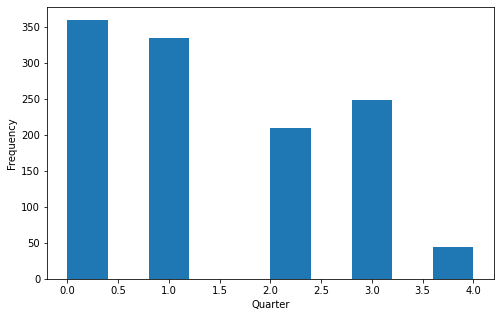

In [19]:
plt.figure(figsize=(8,5))
plt.xlabel('Quarter')
plt.ylabel('Frequency')
train_data['quarter'].plot.hist()

In [12]:
train_data.drop(['date'],1,inplace=True)

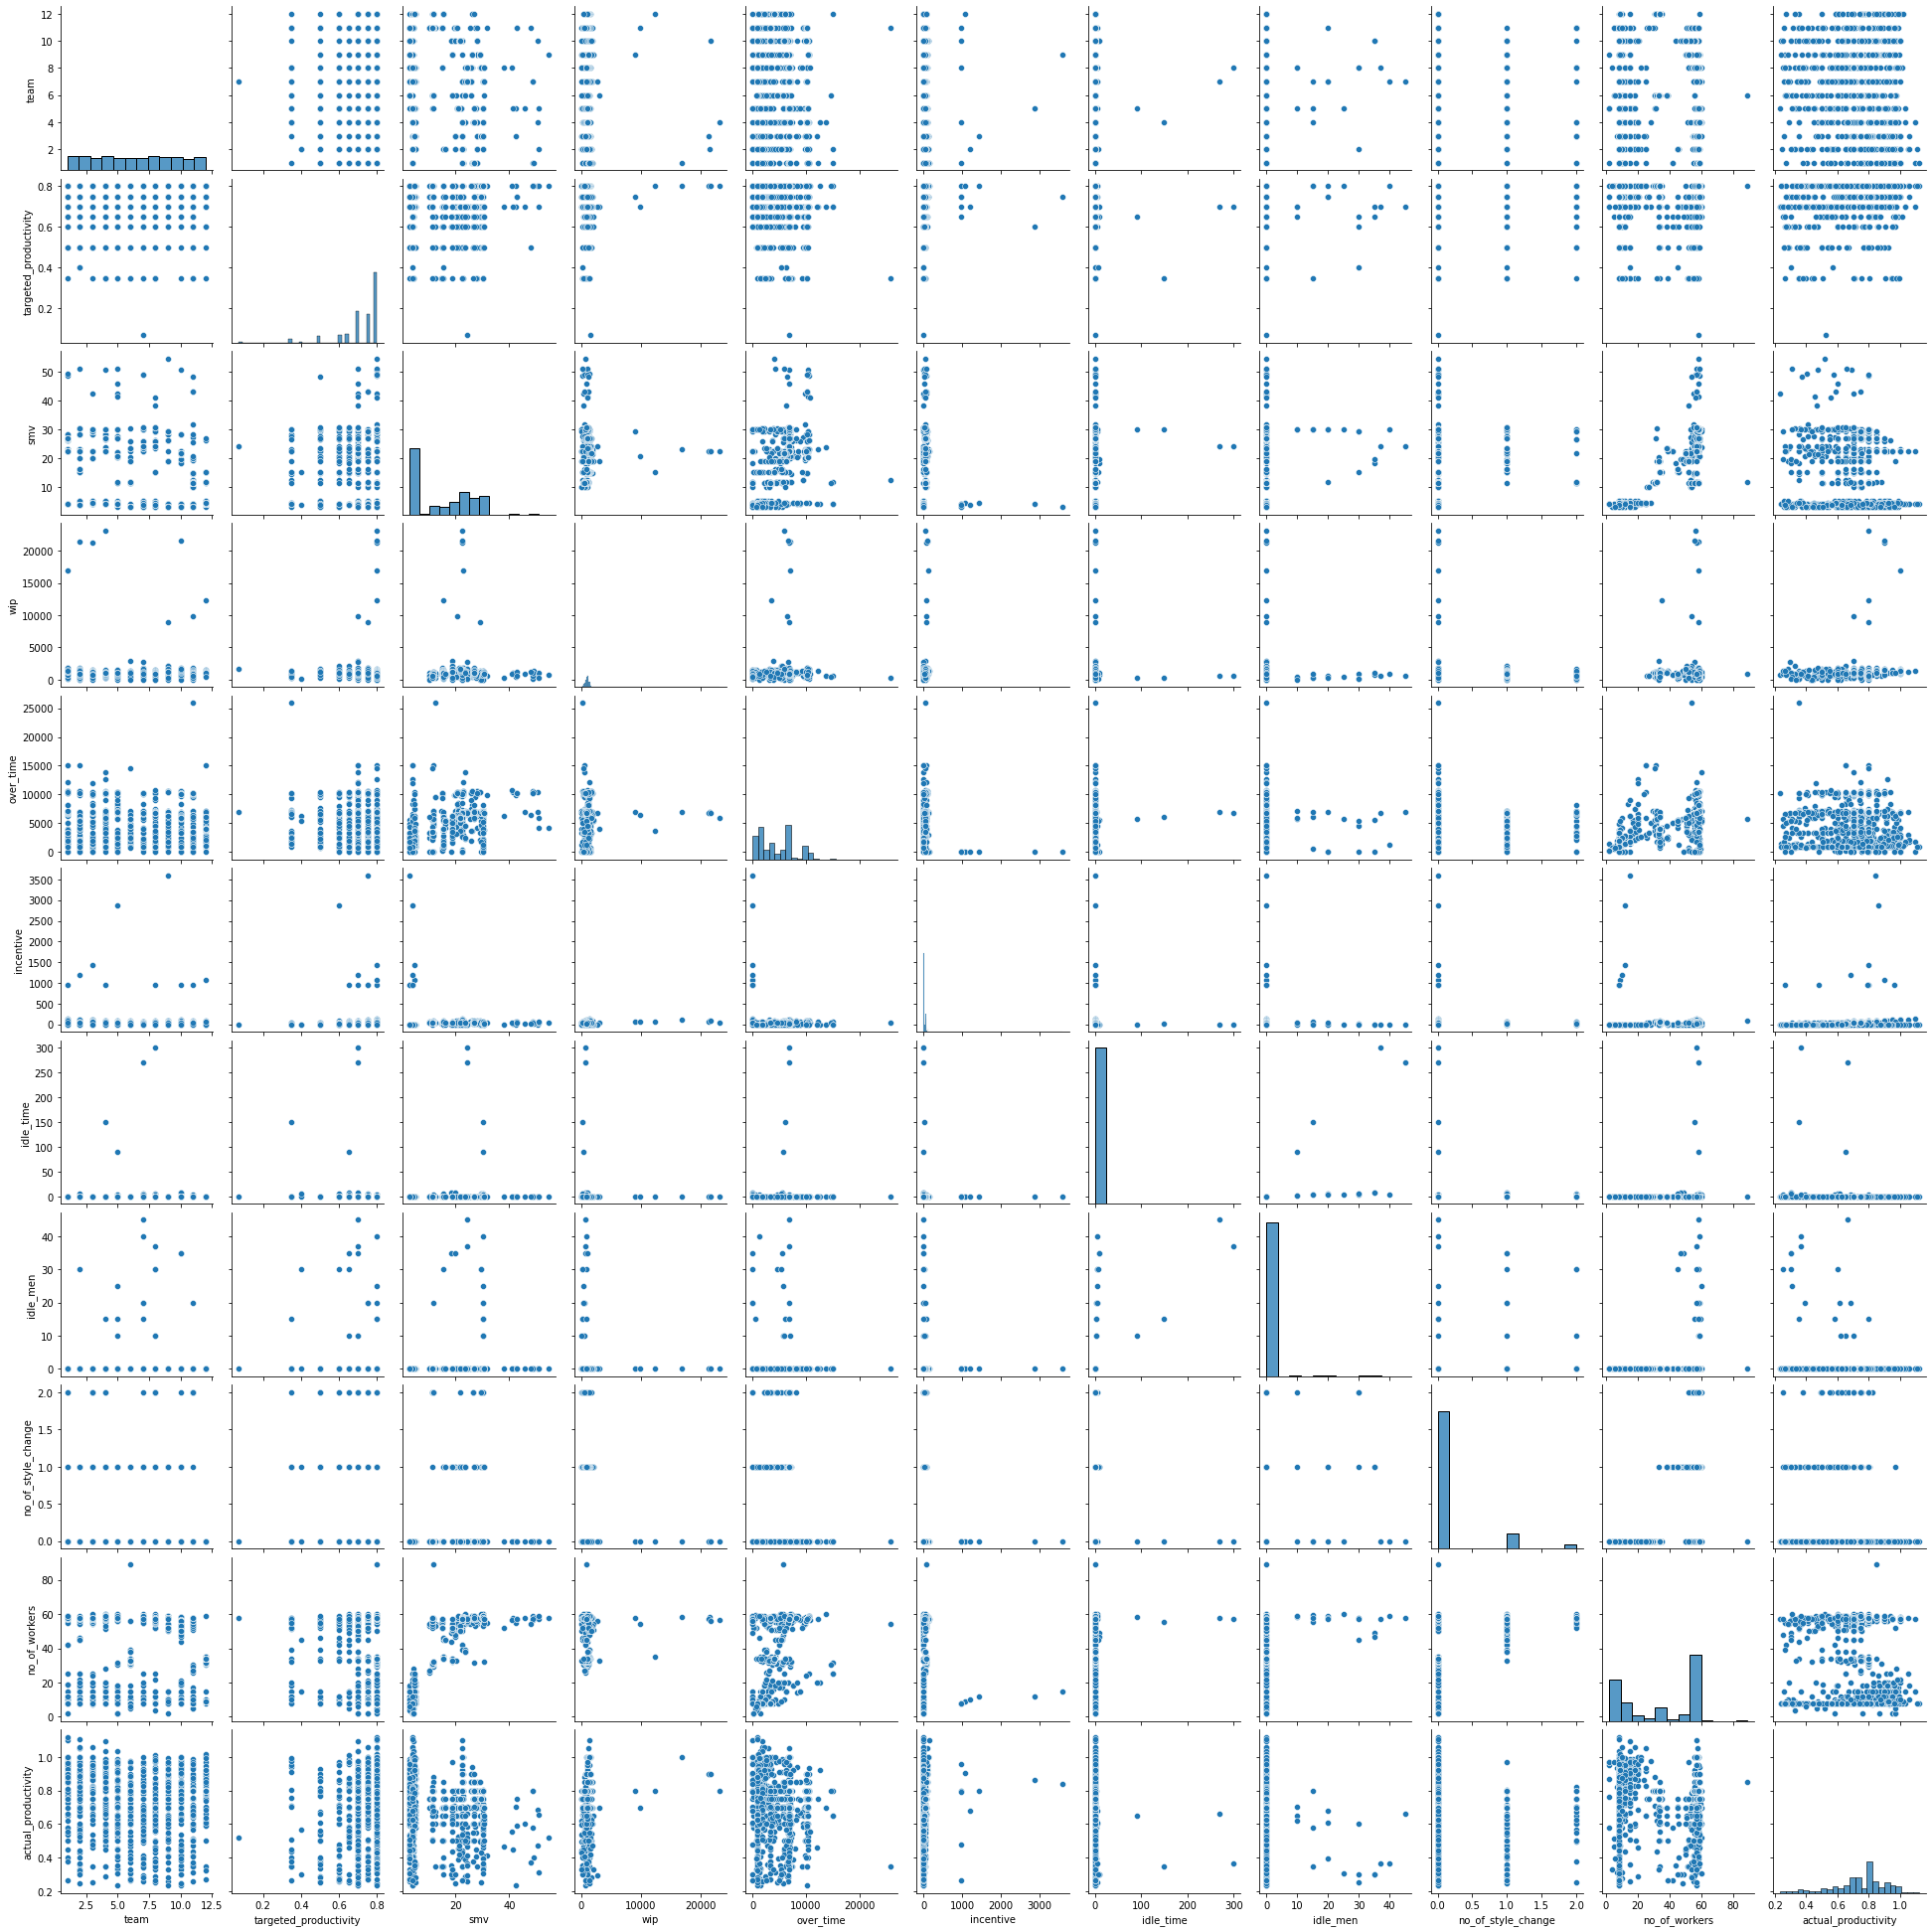

In [13]:
sns.pairplot(train_data)

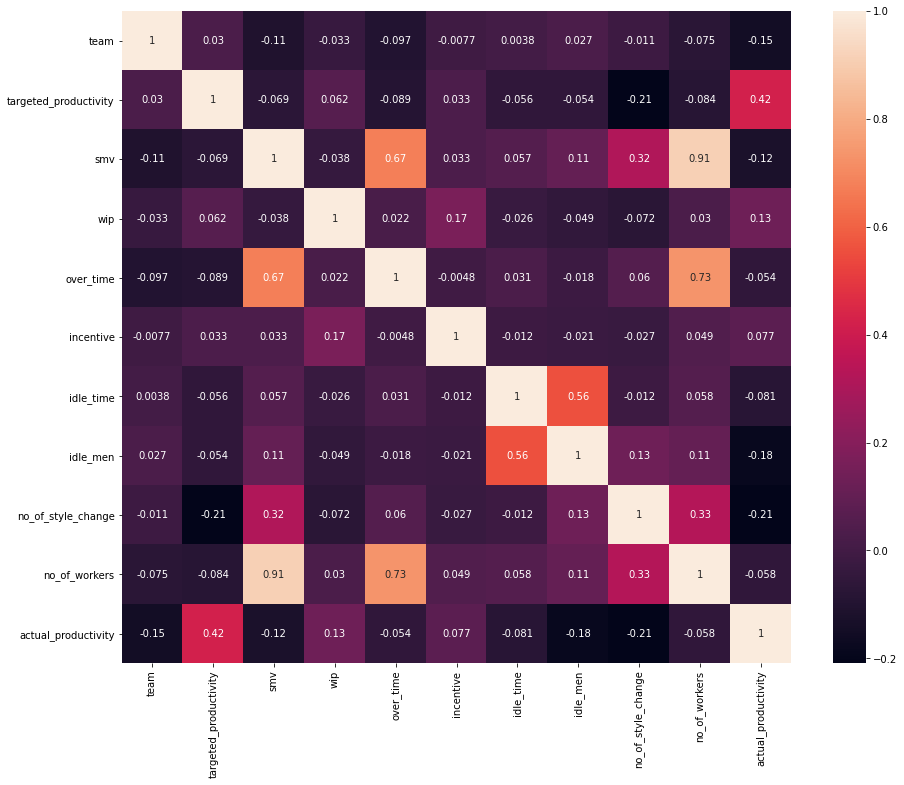

In [14]:
plt.figure(figsize=(15,12))
sns.heatmap(train_data.corr(),annot=True)

##Label Encoding

I did not label encoded the department variable because it was creating a high multicollinearity with [no. of workers] and [smv]. So I used another approach.

In [15]:
to_labelencode = train_data[['day', 'quarter']]
le = LabelEncoder()
label_encoded_features = to_labelencode.apply(le.fit_transform)

In [16]:
train_data.drop(['day', 'quarter'],1,inplace=True)

train_data = label_encoded_features.join(train_data)
train_data

,day,quarter,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,3,0,sweing,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,3,0,finishing,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,3,0,sweing,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,3,0,sweing,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,3,0,sweing,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,5,1,finishing,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,5,1,finishing,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,5,1,finishing,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,5,1,finishing,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


Deleting [no. of workers] as it is to reduce multicollinearity effect.

In [17]:
train_data.drop(['no_of_workers'],1,inplace=True)

##BaseN Encoding

This is BaseN Encoder has default base=2, which means this will work as binary encoder. We can also specifiy base = 1,3,5,10 and others too. base=1 works as one hot encoder. [BaseN encoding link](https://contrib.scikit-learn.org/category_encoders/basen.html)

In [20]:
basen = BaseNEncoder(base=2, cols = train_data[['department']], return_df=True )
basen_encoded_feature = basen.fit_transform(train_data[['department']])

# 0 = sweing & 1 = finishing
print(basen_encoded_feature)

basen_encoded_feature.drop(['department_1'],1,inplace=True)

      department_0  department_1
0                0             1
1                1             0
2                0             1
3                0             1
4                0             1
...            ...           ...
1192             1             0
1193             1             0
1194             1             0
1195             1             0
1196             1             0

[1197 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [21]:
train_data.drop(['department'],1,inplace=True)

In [22]:
baseN_train_data = basen_encoded_feature.join(train_data)
baseN_train_data = baseN_train_data.rename(columns={'department_0' : 'department'})

##MICE Imputation

In [46]:
lr = LinearRegression()
mice_imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10, n_nearest_features=2, imputation_order = 'ascending')
cleaned_train_data = mice_imputer.fit_transform(baseN_train_data)

cleaned_train_data = pd.DataFrame(cleaned_train_data)
cleaned_train_data.columns = ['quarter', 'department', 'day  ', 'team', 'targeted_productivity',
                              'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
                              'no_of_style_change', 'actual_productivity']
                                                        
cleaned_train_data

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,actual_productivity
0,0.0,3.0,0.0,8.0,0.80,26.16,1108.000000,7080.0,98.0,0.0,0.0,0.0,0.940725
1,1.0,3.0,0.0,1.0,0.75,3.94,1365.751658,960.0,0.0,0.0,0.0,0.0,0.886500
2,0.0,3.0,0.0,11.0,0.80,11.41,968.000000,3660.0,50.0,0.0,0.0,0.0,0.800570
3,0.0,3.0,0.0,12.0,0.80,11.41,968.000000,3660.0,50.0,0.0,0.0,0.0,0.800570
4,0.0,3.0,0.0,6.0,0.80,25.90,1170.000000,1920.0,50.0,0.0,0.0,0.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,1.0,5.0,1.0,10.0,0.75,2.90,624.586970,960.0,0.0,0.0,0.0,0.0,0.628333
1193,1.0,5.0,1.0,8.0,0.70,3.90,620.409611,960.0,0.0,0.0,0.0,0.0,0.625625
1194,1.0,5.0,1.0,7.0,0.65,3.90,620.409611,960.0,0.0,0.0,0.0,0.0,0.625625
1195,1.0,5.0,1.0,9.0,0.75,2.90,435.727503,1800.0,0.0,0.0,0.0,0.0,0.505889


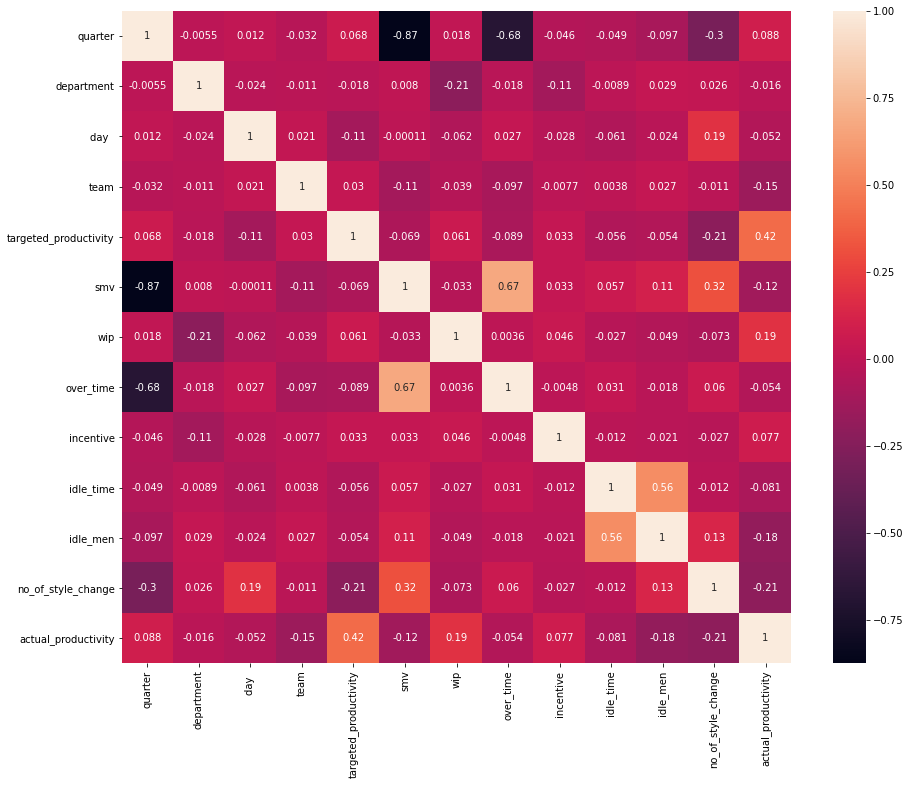

In [47]:
plt.figure(figsize=(15,12))
sns.heatmap(cleaned_train_data.corr(),annot=True)

##Skewness Normalizing

There is high skewness for some columns. I need to normalize it.

In [48]:
cleaned_train_data.skew()

quarter                   0.313258
department               -0.029637
day                       0.386482
team                      0.009848
targeted_productivity    -2.144150
smv                       0.405937
wip                      12.033181
over_time                 0.673287
incentive                15.790746
idle_time                20.545425
idle_men                  9.855079
no_of_style_change        2.942506
actual_productivity      -0.807492
dtype: float64

I Must delete this type of columns(idle_time, idle_men) which are called as quasi constant i.e. almost constant means single value holds the most frequency. This columns can be useful in visualization when the manager wants to know the reason of interuptions in work. For prediction this are not useful.

In [49]:
cleaned_train_data['idle_time'].value_counts(), cleaned_train_data['idle_men'].value_counts()

(0.0      1179
 3.5         3
 4.0         2
 4.5         2
 8.0         2
 5.0         2
 2.0         2
 270.0       1
 150.0       1
 6.5         1
 300.0       1
 90.0        1
 Name: idle_time, dtype: int64, 0.0     1179
 20.0       3
 30.0       3
 15.0       3
 10.0       3
 35.0       2
 40.0       1
 25.0       1
 37.0       1
 45.0       1
 Name: idle_men, dtype: int64)

In [50]:
cleaned_train_data.drop(['idle_time', 'idle_men'],1,inplace=True)

###sqrt transformation

In [51]:
data = cleaned_train_data[['wip', 'incentive']]
sqrt_transform = np.sqrt(data)

cleaned_train_data.drop(['wip', 'incentive'],1,inplace=True)

cleaned_train_data = sqrt_transform.join(cleaned_train_data)

I again sqrt transformed it and not I got better results

In [52]:
cleaned_train_data['wip'] = np.sqrt(cleaned_train_data['wip'])

In [53]:
cleaned_train_data.skew()

wip                      1.104043
incentive                3.562218
quarter                  0.313258
department              -0.029637
day                      0.386482
team                     0.009848
targeted_productivity   -2.144150
smv                      0.405937
over_time                0.673287
no_of_style_change       2.942506
actual_productivity     -0.807492
dtype: float64

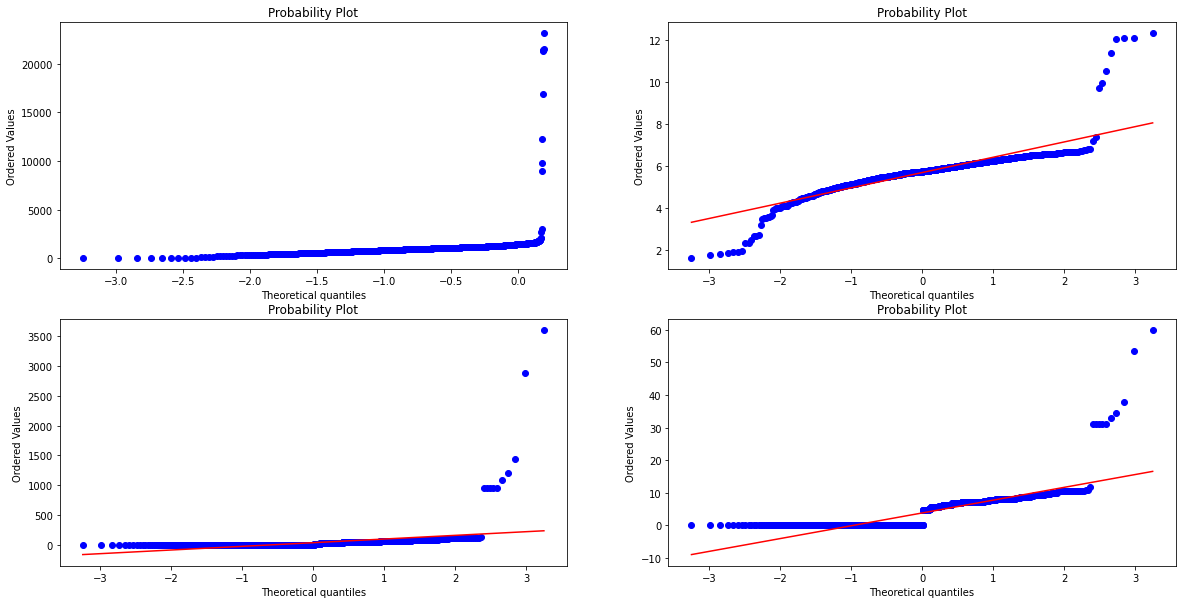

In [54]:
import scipy.stats as stats
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
stats.probplot(train_data['wip'], dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(cleaned_train_data['wip'], dist="norm", plot=plt)
plt.subplot(2,2,3)
stats.probplot(train_data['incentive'], dist="norm", plot=plt)
plt.subplot(2,2,4)
stats.probplot(cleaned_train_data['incentive'], dist="norm", plot=plt)
plt.show()

In [55]:
cleaned_train_data = pd.DataFrame(cleaned_train_data)

In [56]:
cleaned_train_data.to_csv('garments_cleaned_train_data.csv',index=False)